In [ ]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 24 * 10)}, None,
)
da_T = exp_T.da

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
ds_pvs, ds_pvs_anoms = open_pvs(da_s)
da_jet_pos = jet_position_as_da(da_s, props_as_ds, props_as_ds_uncat, all_jets,exp_s.path)

In [ ]:
net, centers, labels = exp_s.compute_som(
    6,
    6,
    200,
    return_type=ADJUST_REALSPACE,
    train_kwargs=dict(train_algo="batch", epochs=1000),
)

n_samples = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_none = mask[:, 0]
mask = mask[:, 1:]
center_none = centers[0]
centers = centers[1:]
centers_all_jets = find_all_jets(centers, height=25, cutoff_blobs=750, cutoff_jets=1200, chunksize=3)
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds = props_to_ds(centers_props, centers.cluster)

bmus_da = xr.DataArray(net.bmus, coords={'time': da_s.time.values})
labels_daily = bmus_da.interp(coords={'time': da_T.time.values}, method='nearest').astype(int).values
mask_daily = labels_to_mask(labels_daily)
populations = (centers.ratios.values * len(da_s.time)).astype(int)

2023-12-05 15:40:27.970 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2023-12-05 15:40:27.976 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2023-12-05 15:40:28.044 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file
100%|██████████| 36/36 [00:00<00:00, 425.98it/s]


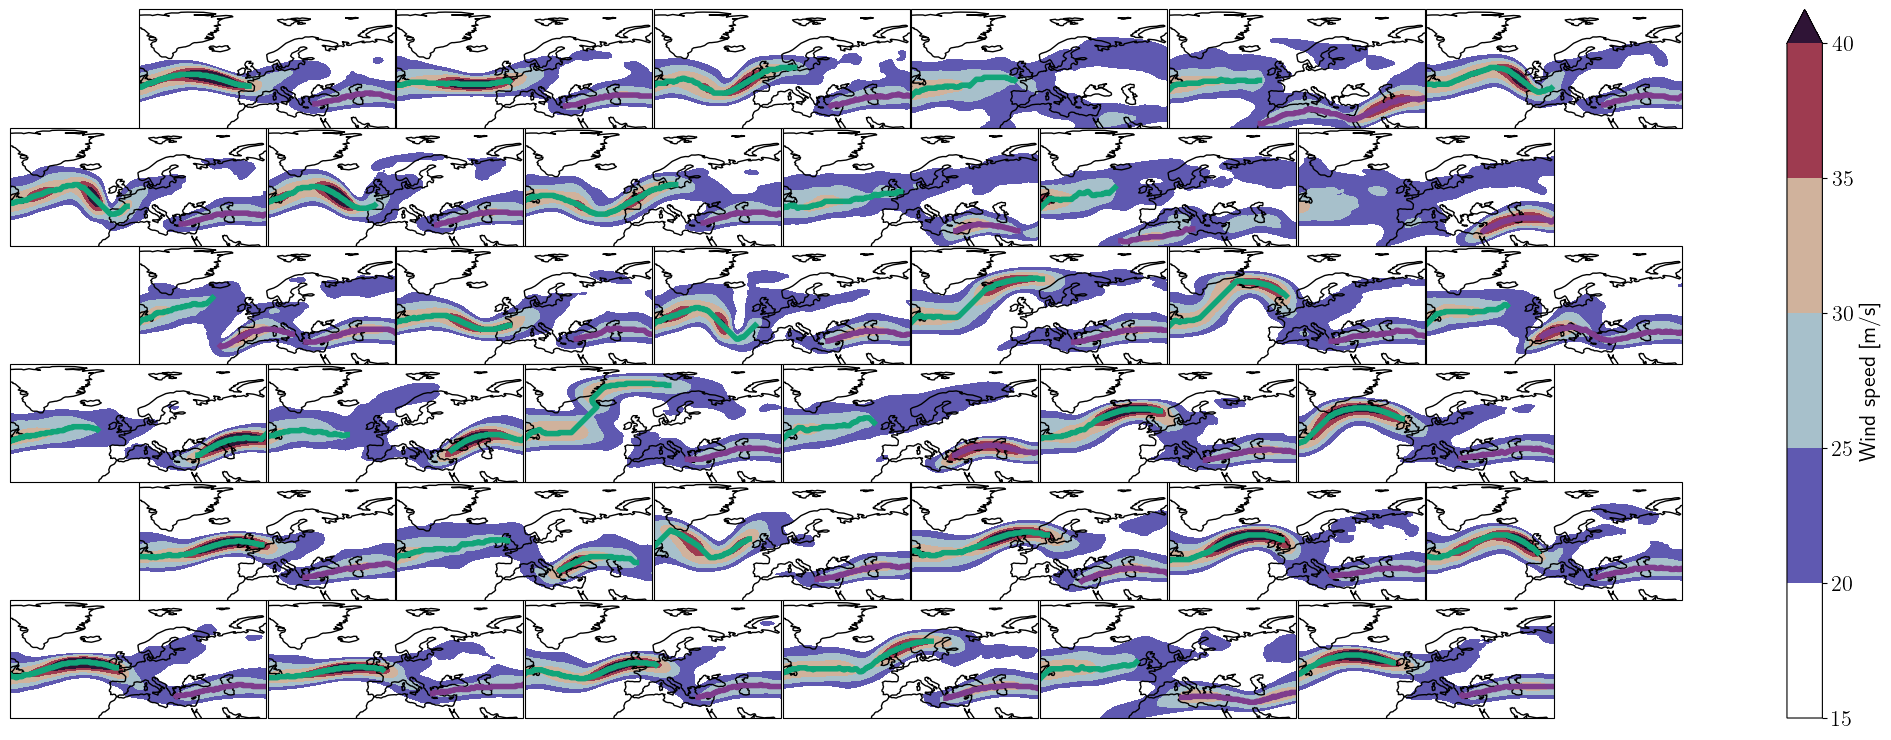

In [ ]:
clu = Clusterplot(net.width, net.height, exp_s.region, honeycomb=True)
_, clu.add_contourf(
    centers,
    cmap='twilight_shifted',
    start=15,
    nlevels=6,
    transparify=1,
    cbar_label="Wind speed [m/s]",
)

colors = cmaps.bold(np.arange(12))
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=colors[int(is_p)], lw=4)
plt.savefig(f'{FIGURES}/som_composites/SOM_wind_speed.png')


100%|██████████| 36/36 [00:53<00:00,  1.47s/it]


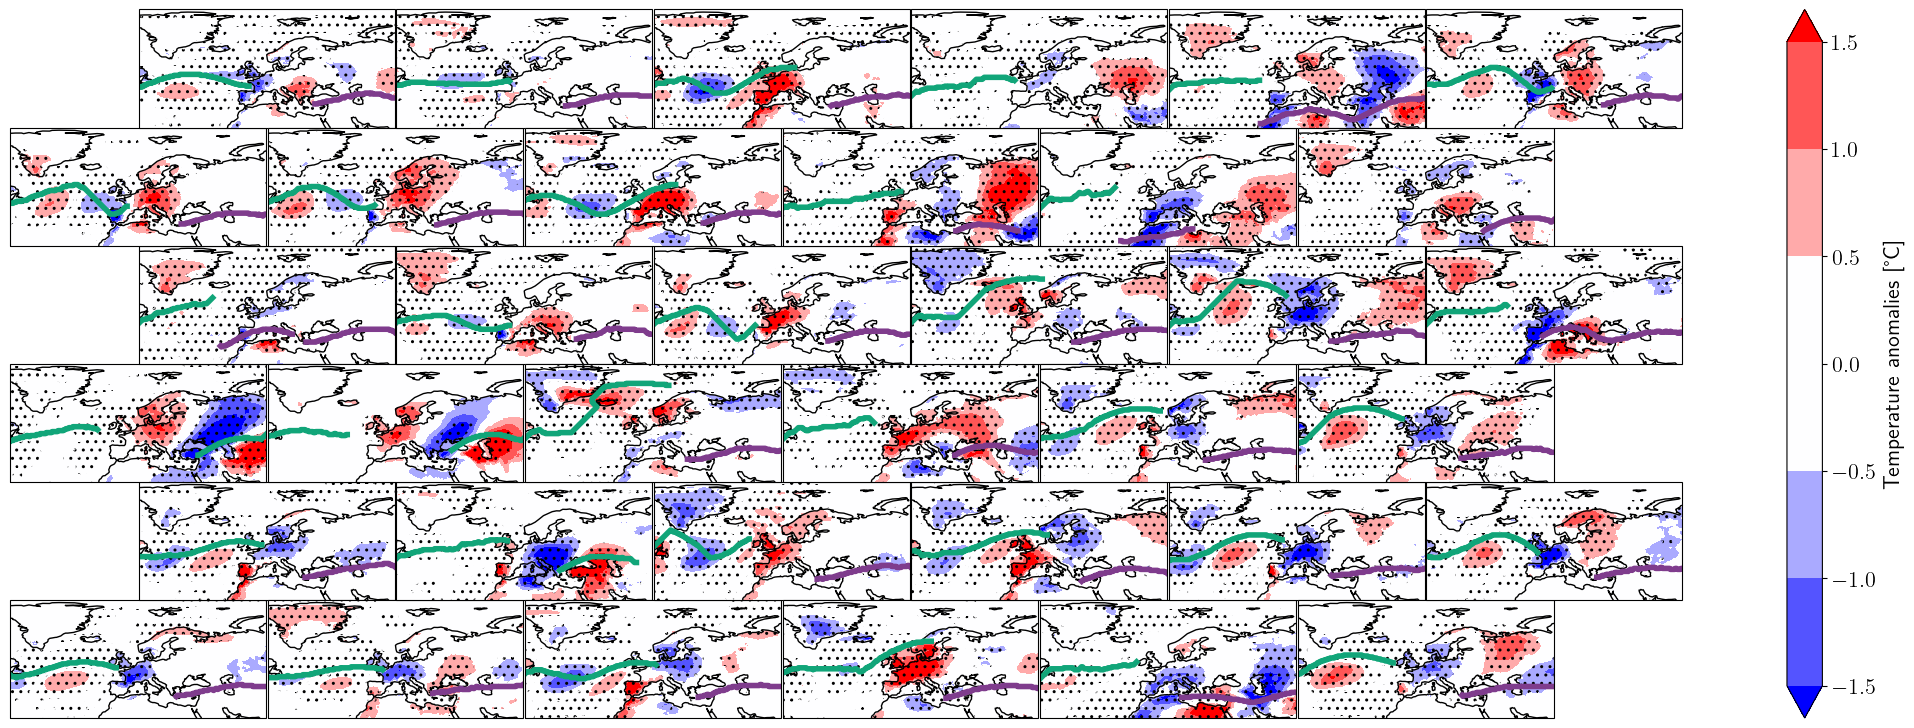

In [ ]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_T, mask, "contourf", stippling=True, cbar_label="Temperature anomalies [°C]", cmap='bwr'
)
# clu.cluster_on_fig(coords, meta_labels, cmap=['Grey', '#4bbe58', '#ae279e'])
colors = cmaps.bold(np.arange(12))
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=colors[int(is_p)], lw=4)
plt.savefig(f'{FIGURES}/som_composites/SOM_temp.png')


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


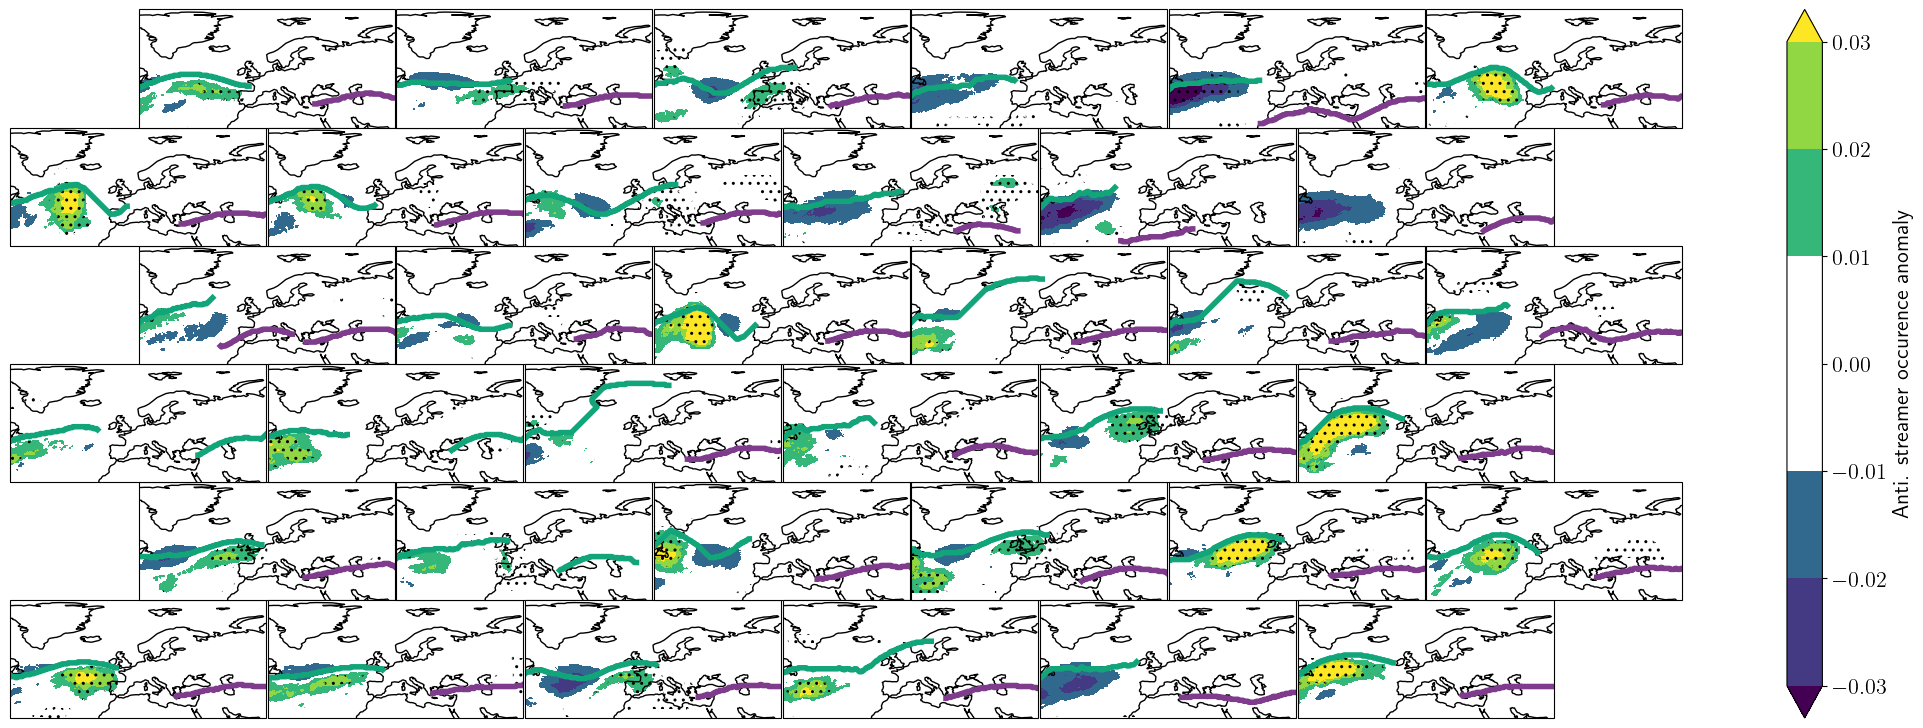

In [ ]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clu.add_any_contour_from_mask(
        ds_pvs_anoms['anti'], mask[6992:], "contourf", stippling=True, cbar_label="Anti. streamer occurence anomaly", transparify=1, cmap='viridis', q=0.995
    )
colors = cmaps.bold(np.arange(12))
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=colors[int(is_p)], lw=4)
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_apvs.png')

 67%|██████▋   | 24/36 [00:01<00:00, 14.43it/s]

100%|██████████| 36/36 [00:41<00:00,  1.15s/it]


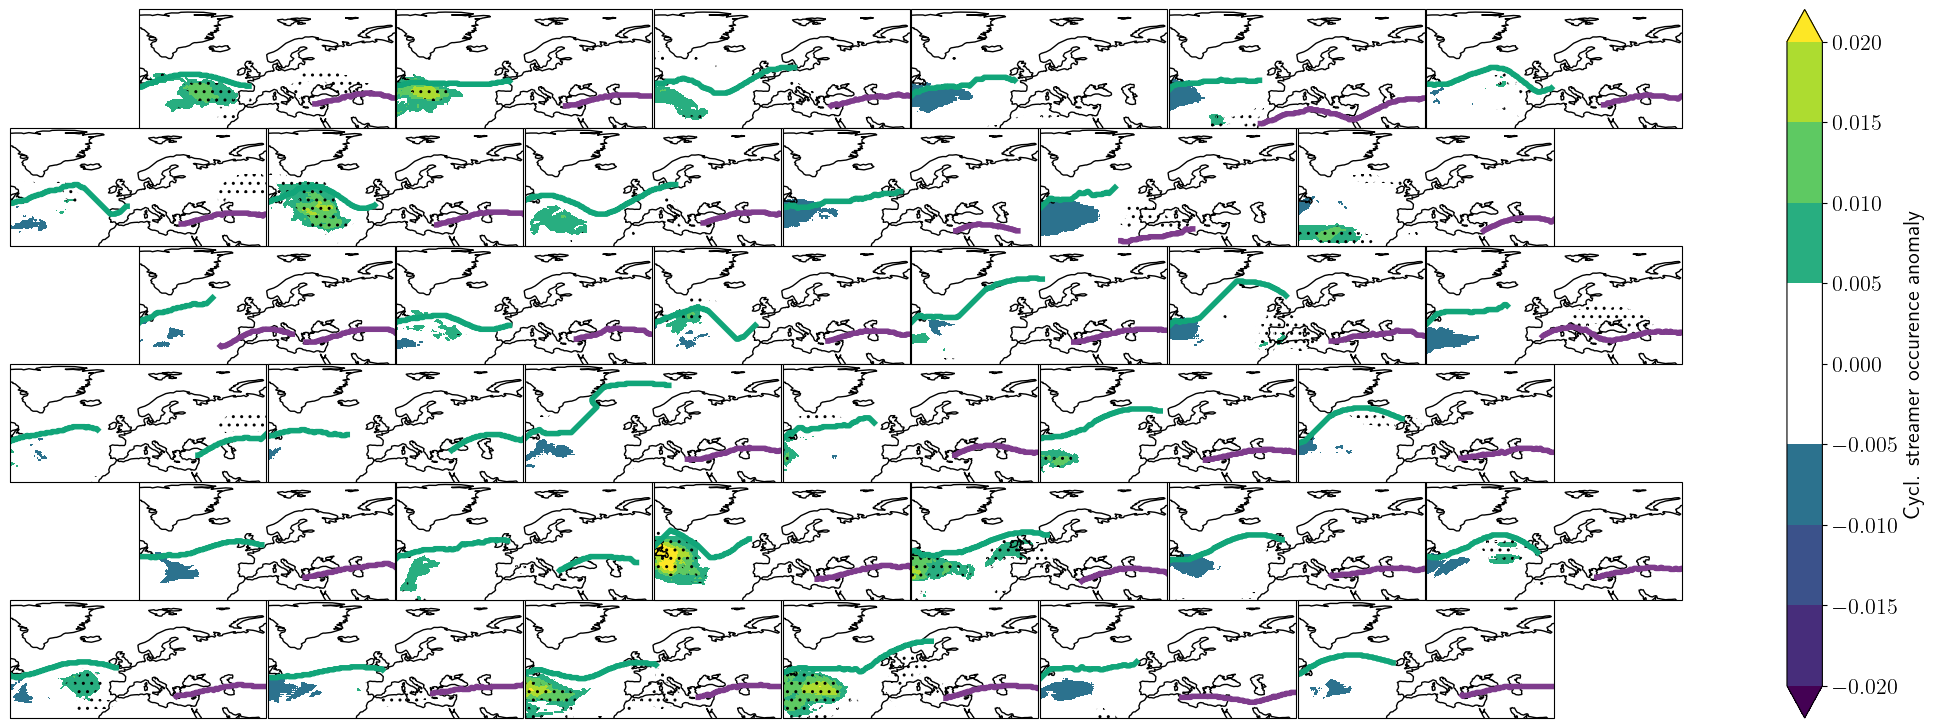

In [ ]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clu.add_any_contour_from_mask(
        ds_pvs_anoms['cycl'], mask[6992:], "contourf", stippling=True, cbar_label="Cycl. streamer occurence anomaly", transparify=1, cmap='viridis', q=0.999
    )
colors = cmaps.bold(np.arange(12))
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color=colors[int(is_p)], lw=4)
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_cpvs.png')

100%|██████████| 36/36 [00:04<00:00,  7.30it/s]


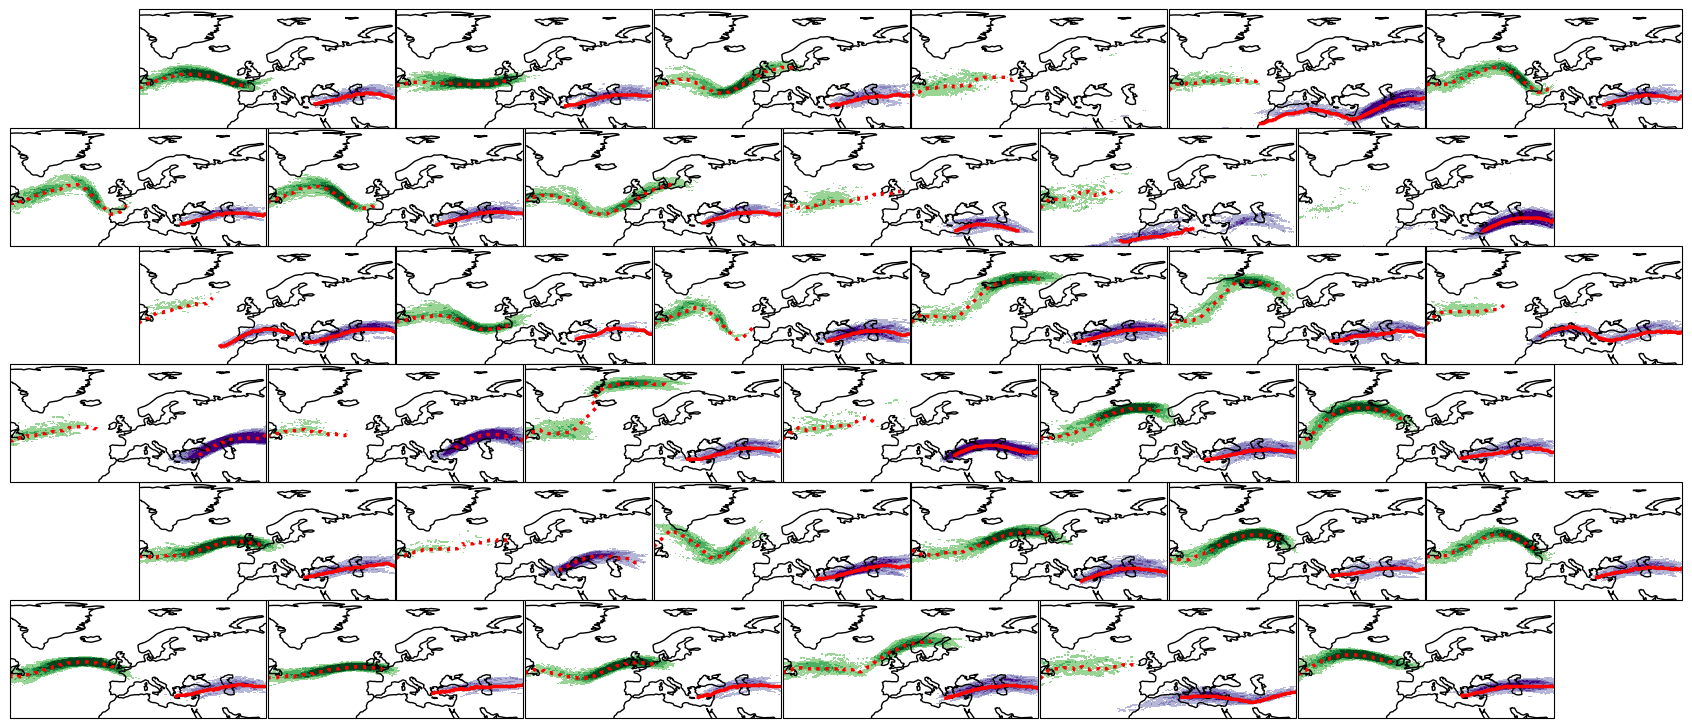

In [ ]:
clu = Clusterplot(net.width, net.height, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 1] / da_jet_pos[:, 1].max(), mask, cbar_label="Polar jet occurence", transparify=2, cmap='Greens', draw_cbar=False,
)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 0] / da_jet_pos[:, 0].max(), mask, cbar_label="Subtropical jet occurence", transparify=2, cmap='Purples', draw_cbar=False,
)
# clu.add_any_contour_from_mask(
#     da_pvs_anoms, mask[6992:], "contourf", stippling=False, cbar_label="Streamer occurence anomaly", transparify=2, cmap='bwr'
# )
# colors = cmaps.bold(np.arange(12))
linestyles = ['solid', 'dotted']
is_polar = centers_props_ds['is_polar']
for ax, is_pol, jets in zip(clu.axes, is_polar.values, centers_all_jets):
    for j, (jet, is_p) in enumerate(zip(jets, is_pol)):
        x, y, s = jet.T
        ax.plot(x, y, color='red', ls=linestyles[int(is_p)], lw=2.5)

clu.fig.set_size_inches(*(clu.fig.get_size_inches() * np.array([0.8, 1])))
clu.fig.savefig(f'{FIGURES}/som_composites/SOM_jet_pos.png')